<a href="https://colab.research.google.com/github/yutan0565/Wake-up-Word_tensorflow2/blob/main/Wake_up_word_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작 전 세팅

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install python_speech_features
!pip install playsound
!pip install -q tensorflow-model-optimization
# !pip install pyaudio

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=5ace48755ac4d832415f37436ca9a0be5cb6b8b2a5a56c52d84756bf0100301a
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=7fe907b15dcc33dc2ece2187d06ff2eda591deb120997e3f861b62b46df8ac40
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound
     |████████████████████████████████| 237 kB 8.4 MB/s 


# Data Augmentation - data_augmentation.py

In [2]:
import soundfile as sf
import os
from os import listdir
from os.path import isdir, join
import librosa
import numpy as np
import shutil
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt

from configuration import Config

In [56]:
def plot_time_series(data, title):
    fig = plt.figure(figsize=(7, 4))
    plt.title(title+'  wave')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 5, len(data)), data)
    plt.show()

In [57]:
# Whit Noise
# 기존 소리에 잡음을 넣어줌
def adding_white_noise(data, type, count, sr=16000, noise_rate=0.001):
    # noise 방식으로 일반적으로 쓰는 잡음 끼게 하는 겁니다.
    sig, sr = librosa.load(data, sr=16000)
    wn = np.random.randn(len(sig))
    data_wn = sig + noise_rate*wn
    sf.write( Config.base_path+ Config.dataset_type+'/' + type +'/'+type+'_white_noise'+'{0:04d}'.format(count)+'.wav', data_wn, sr)
    return data_wn

In [58]:
#stretch_sound
# 테이프 늘어진 것처럼 들린다.
def stretch_sound(data, type, count, sr=16000, rate=0.8):
    sig, sr = librosa.load(data, sr=16000)
    stretch_data = librosa.effects.time_stretch(sig, rate)
    sf.write( Config.base_path+Config.dataset_type+'/' + type +'/'+type+'_stretch_sound'+'{0:04d}'.format(count)+'.wav', stretch_data, sr)
    return stretch_data

In [59]:
# minus_sound
# x 축 기준으로 뒤집기 (사람에게는 똑같이 들림)
def minus_sound(data, type, count, sr=16000):
    sig, sr = librosa.load(data, sr=16000)
    temp_numpy = (-1)*sig
    sf.write( Config.base_path+Config.dataset_type+'/' + type +'/'+type+'_reverse_data'+'{0:04d}'.format(count)+'.wav', temp_numpy, sr)
    return temp_numpy

In [60]:

for index, type in enumerate(Config.target_list):
  print('/'.join([Config.aug_dataset_path, type])) 
  type_path = '/'.join([Config.aug_dataset_path, type])
  if not os.path.exists(Config.dataset_path):
            os.makedirs(Config.dataset_path)

  if not os.path.exists(Config.dataset_path+'/' + type):
            os.makedirs(Config.dataset_path+'/' + type)
  all_file = listdir(type_path)
  count = 1
  aug_cut = len(all_file) * Config.aug_rate
  for file_name in all_file:
    if count > aug_cut:
      break
    file_path =  type_path + "/"+file_name
    print(file_path, count)
    adding_white_noise(file_path, type, count)
    stretch_sound(file_path, type, count)
    minus_sound(file_path, type, count)
    copy_tree(type_path, Config.dataset_path+'/' + type )
    count += 1

['hey_tantan', 'hi_byeonghyeon', 'hi_jeonglyul', 'hi_sungwoo', 'hi_yutan', 'no']
./custum_dataset/hey_tantan
./custum_dataset/hey_tantan/voice0001_hey_tantan.wav 1


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Pass rate=0.8 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  """


./custum_dataset/hey_tantan/voice0002_hey_tantan.wav 2
./custum_dataset/hey_tantan/voice0003_hey_tantan.wav 3
./custum_dataset/hey_tantan/voice0004_hey_tantan.wav 4
./custum_dataset/hey_tantan/voice0005_hey_tantan.wav 5
./custum_dataset/hey_tantan/voice0006_hey_tantan.wav 6
./custum_dataset/hey_tantan/voice0007_hey_tantan.wav 7
./custum_dataset/hey_tantan/voice0008_hey_tantan.wav 8
./custum_dataset/hey_tantan/voice0009_hey_tantan.wav 9
./custum_dataset/hey_tantan/voice0010_hey_tantan.wav 10
./custum_dataset/hey_tantan/voice0011_hey_tantan.wav 11
./custum_dataset/hey_tantan/voice0012_hey_tantan.wav 12
./custum_dataset/hey_tantan/voice0013_hey_tantan.wav 13
./custum_dataset/hey_tantan/voice0014_hey_tantan.wav 14
./custum_dataset/hey_tantan/voice0015_hey_tantan.wav 15
./custum_dataset/hey_tantan/voice0016_hey_tantan.wav 16
./custum_dataset/hey_tantan/voice0017_hey_tantan.wav 17
./custum_dataset/hey_tantan/voice0018_hey_tantan.wav 18
./custum_dataset/hey_tantan/voice0019_hey_tantan.wav 19


./custum_dataset/hi_sungwoo/voice0003_hi_sungwoo.wav 3
./custum_dataset/hi_sungwoo/voice0004_hi_sungwoo.wav 4
./custum_dataset/hi_sungwoo/voice0005_hi_sungwoo.wav 5
./custum_dataset/hi_sungwoo/voice0006_hi_sungwoo.wav 6
./custum_dataset/hi_sungwoo/voice0007_hi_sungwoo.wav 7
./custum_dataset/hi_sungwoo/voice0008_hi_sungwoo.wav 8
./custum_dataset/hi_sungwoo/voice0009_hi_sungwoo.wav 9
./custum_dataset/hi_sungwoo/voice0010_hi_sungwoo.wav 10
./custum_dataset/hi_sungwoo/voice0011_hi_sungwoo.wav 11
./custum_dataset/hi_sungwoo/voice0012_hi_sungwoo.wav 12
./custum_dataset/hi_sungwoo/voice0013_hi_sungwoo.wav 13
./custum_dataset/hi_sungwoo/voice0014_hi_sungwoo.wav 14
./custum_dataset/hi_sungwoo/voice0015_hi_sungwoo.wav 15
./custum_dataset/hi_sungwoo/voice0016_hi_sungwoo.wav 16
./custum_dataset/hi_sungwoo/voice0017_hi_sungwoo.wav 17
./custum_dataset/hi_sungwoo/voice0018_hi_sungwoo.wav 18
./custum_dataset/hi_sungwoo/voice0019_hi_sungwoo.wav 19
./custum_dataset/hi_sungwoo/voice0020_hi_sungwoo.wav 20

sr: 16000 , sig shape: (44033,)
length: 2.7520625 secs


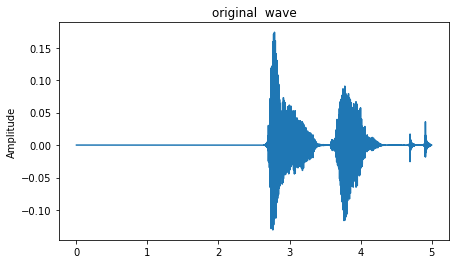

In [61]:
# type = "hi_yutan"
# file = Config.base_path+"/custum_dataset/hi_yutan/voice0015_hi_yutan.wav"

# # a = adding_white_noise(file, type)
# # b= stretch_sound(file, type)
# # c= minus_sound(file, type)

# sig, sr = librosa.load(file, sr=16000)
# print('sr:', sr, ', sig shape:', sig.shape)
# print('length:', sig.shape[0]/float(sr), 'secs')

# plot_time_series(sig, "original")
# # plot_time_series(a,"Noise")
# # plot_time_series(b,"Stretch")
# # plot_time_series(c,"Reverse")

# 데이터 나눠 주기

In [3]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
# import python_speech_features
import librosa.display
import seaborn as sns
from sklearn import metrics
#from playsound import playsound

import tensorflow as tf
from tensorflow.keras import models

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard
import tensorflow_model_optimization as tfmot
from tensorflow import lite

from tensorflow.keras import layers
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape, Conv2D, MaxPooling2D, Flatten

from keras.models import Model, load_model, Sequential
import model
import Config

np.random.seed(77)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1, 3, 128)         41312     
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 180865    
Total params: 222,177
Trainable params: 222,177
Non-trainable params: 0
_________________________________________________________________


In [4]:
filenames = []
y = []
for index, target in enumerate(Config.target_list):
    print('/'.join([Config.dataset_path, target]))  # class 에 맞는 폴더 이름 넣어주기
    filenames.append(listdir('/'.join([Config.dataset_path, target])))
    y.append(np.ones(len(filenames[index])) * index) 

./augmentation_dataset/hey_tantan
./augmentation_dataset/hi_byeonghyeon
./augmentation_dataset/hi_jeonglyul
./augmentation_dataset/hi_sungwoo
./augmentation_dataset/hi_yutan
./augmentation_dataset/no


In [5]:
# 하나로 쭉 나열 하기
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

# 여기부터 분배를 잘 해줘야함
# file 모아둔거 한번 섞어 주기
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

val_set_size = int(len(filenames) * Config.val_ratio)
test_set_size = int(len(filenames) * Config.test_ratio)

filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [6]:
print(len(filenames_train), len(y_orig_train))
print(len(filenames_val), len(y_orig_val))
print(len(filenames_test), len(y_orig_test))

737 737
105 105
210 210


# MFCC feature 추출 - MFCC_maker.py

In [7]:
ffts = []
stfts = [] 
f_ffts = []
log_specs = []
MFCCs_list = []

def get_librosa_mfcc(path):
    sig, sr = librosa.core.load(path, Config.sample_rate)
    signal = sig[-Config.sample_cut-Config.click:-Config.click]
#     print('sr:', sr, ', sig shape:', sig.shape)
#     print('length:', sig.shape[0]/float(sr), 'secs')
#     plot_time_series(signal, "original")
    
    fft = np.fft.fft(signal)
    magnitude = np.abs(fft)
    frequency = np.linspace(0, Config.sample_rate, len(magnitude))
    f_ffts.append([frequency, magnitude])
    
    # calculate abs values on complex numbers to get magnitude
    spectrum = np.abs(fft)
    
    # half frequency variable
    f = np.linspace(0, Config.sample_rate, len(spectrum))
    left_spectrum = spectrum[:int(len(spectrum)/2)]
    left_f = f[:int(len(spectrum)/2)]
    ffts.append([left_f, left_spectrum])

    # Short-time FT
    stft = librosa.stft(signal, n_fft=Config.n_fft, hop_length=Config.hop_length)
    spectrogram = np.abs(stft)
    stfts.append([spectrogram, Config.sample_rate, Config.hop_length])
    log_spectrogram = librosa.amplitude_to_db(spectrogram)
    log_specs.append([log_spectrogram, Config.sample_rate, Config.hop_length])
    MFCCs = librosa.feature.mfcc(signal, Config.sample_rate, 
                                 n_mfcc=Config.num_mfcc,
                                 n_fft=Config.n_fft,
                                 hop_length=Config.hop_length)
    MFCCs_list.append([MFCCs, Config.sample_rate, Config.hop_length])
    return MFCCs

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.05645752 -0.0838623  -0.10006714 ...  0.00079346  0.00036621
 -0.00045776], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error


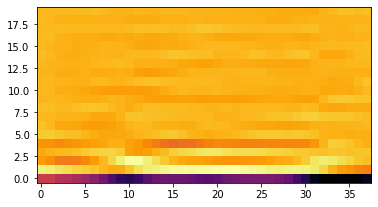

In [8]:
# 내가 확인 할 부분
idx = 1

# Create path from given filename and target item
path = '/'.join([Config.dataset_path, Config.target_list[int(y_orig_train[idx])], 
            filenames_train[idx]])

# mfcc 만들기
mfccs = get_librosa_mfcc(path)

# MFCC 그림으로 보기
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# # 소리 확인
# print(Config.target_list[int(y_orig_train[idx])])
# print(path)
# playsound(path)

In [9]:
# 학습 하기 전에 미리 모든 소리에 대해서 feature 추출해서 준비 해두는 단계, inpu을 맞추려고 
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
    
        # Create path from given filename and target item
        path = "/".join([Config.dataset_path, Config.target_list[int(in_y[index])], 
                    filename])
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = get_librosa_mfcc(path)

        if mfccs.shape[1] == Config.len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [10]:
x_train, y_train, prob_train = extract_features(filenames_train, y_orig_train)
x_val, y_val, prob_val = extract_features(filenames_val, y_orig_val)
x_test, y_test, prob_test = extract_features(filenames_test, y_orig_test)

print("Train 잃은거{}".format(prob_train / len(y_orig_train)))
print("Valid 잃은거{}".format(prob_val / len(y_orig_val)))
print("Test 잃은거{}".format(prob_test / len(y_orig_test)))

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[3.1528667e-05 2.9591652e-05 3.1793537e-05 ... 7.8778918e-05 1.0335069e-04
 5.6088007e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.05645752 -0.0838623  -0.10006714 ...  0.00079346  0.00036621
 -0.00045776], sr=16000 as keyword args. From version 0.10 passing these as positional arguments 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.00038872 -0.00034091 -0.00040217 ... -0.0011116  -0.00012344
 -0.00022203], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00509644  0.00210571  0.00439453 ... -0.00064087 -0.00073242
  0.00027466], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.0517578e-05 -3.0517578e-05  0.0000000e+00 ... -6.7138672e-04
  5.4931641e-04  1.5258789e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pas

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 4.7818071e-07  4.5235229e-06  5.9736169e-05 ... -5.5735301e-05
 -5.2942294e-05 -2.4186420e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.01205444  0.00018311 -0.00228882 ... -0.00015259 -0.0005188
 -0.00280762], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 3.0517578e-05  0.0000000e+00 -6.1035156e-05 ...  2.7465820e-04
  3.3569336e-04 -8.8500977e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: F

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 3.6839551e-06 -1.7107483e-05 -4.5732755e-05 ...  1.0013624e-02
  1.1570403e-02  1.3792728e-02], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.00030518  0.0010376   0.00061035 ... -0.0010376  -0.00048828
  0.00198364], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00354004  0.01174927  0.01721191 ... -0.00073242  0.00054932
 -0.00030518], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pas

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-6.6109328e-06  1.7664763e-05  2.8703704e-05 ...  4.0045840e-04
  4.3024606e-04  4.5464604e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.01705933  0.01843262  0.01858521 ...  0.00076294 -0.00030518
 -0.00076294], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00732422  0.00619507  0.00491333 ... -0.00027466  0.00109863
  0.00027466], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pas

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-5.4931641e-04 -1.1291504e-03 -6.1035156e-05 ... -3.0517578e-04
 -1.2207031e-04 -5.1879883e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 1.2207031e-04 -2.6855469e-03 -1.0314941e-02 ... -1.3122559e-03
 -6.1035156e-05  1.2512207e-03], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.5258789e-04 -1.2207031e-04 -9.1552734e-05 ... -1.8310547e-04
 -1.2207031e-04 -1.2207031e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00015259  0.00109863 -0.00018311 ...  0.00085449  0.00219727
  0.00039673], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.0831078e-04 -9.9006218e-05 -1.2617075e-04 ... -4.0483908e-05
 -5.7184585e-05  8.7895330e-08], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.01254272 -0.05551147 -0.07867432 ...  0.00097656 -0.00054932
  0.00112915], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pas

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 3.0517578e-05  3.0517578e-05  0.0000000e+00 ... -1.2207031e-04
 -1.2207031e-04 -1.2207031e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.00100708  0.00161743  0.00820923 ... -0.00097656 -0.00015259
 -0.00018311], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.00064087  0.00030518 -0.00039673 ...  0.00119019 -0.00033569
  0.00106812], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pas

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 6.1035156e-05  0.0000000e+00 -3.0517578e-05 ...  6.1035156e-05
  0.0000000e+00  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.2196045e-02 -3.2135010e-02 -3.2928467e-02 ... -3.9672852e-04
 -3.0517578e-05  6.4086914e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 3.9608512e-06 -4.0488413e-08 -2.1659169e-05 ... -9.4629213e-06
  4.1469633e-05 -3.8153594e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-9.1552734e-05 -1.2207031e-04 -1.2207031e-04 ... -1.5258789e-04
 -9.1552734e-05 -9.1552734e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.01229858  0.01150513  0.01177979 ... -0.00115967 -0.00057983
  0.00012207], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.01373291 -0.01376343 -0.01309204 ...  0.00192261  0.00247192
 -0.00204468], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pas

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-2.1362305e-04 -4.2724609e-04 -1.3732910e-03 ...  6.4086914e-04
  9.1552734e-05  6.1035156e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00033569  0.00012207 -0.00350952 ... -0.00271606 -0.00201416
  0.00042725], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 9.1552734e-05  3.3569336e-04 -1.8310547e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 9.1552734e-05  9.1552734e-05  9.1552734e-05 ... -1.8310547e-04
  1.2207031e-04  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.05014396e-05  3.24514417e-06  2.38117882e-05 ...  1.18084545e-05
  1.32133562e-06  3.40263396e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.00158691 -0.00021362  0.00180054 ... -0.00045776 -0.00015259
  0.00094604], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.p

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-4.8097008e-05 -5.7147736e-05 -6.8080539e-05 ... -6.4017899e-05
 -1.9374347e-05  1.6153274e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.0517578e-05  0.0000000e+00 -3.0517578e-05 ...  0.0000000e+00
 -6.1035156e-05  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 9.4604492e-04  9.4604492e-04  9.1552734e-05 ... -1.3122559e-03
  3.0517578e-05 -7.0190430e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 5.2189162e-06  4.8764567e-05  6.7279958e-05 ...  5.1380561e-05
 -2.6054535e-05 -6.0007544e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.5777588e-02 -1.6876221e-02 -1.6754150e-02 ...  6.1035156e-05
 -9.1552734e-05  3.0517578e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-4.0440514e-06  1.0180772e-05  3.1132397e-05 ... -1.7233748e-05
 -5.7222675e-05 -1.9419285e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 2.0080097e-05  3.0625222e-05  3.2204825e-05 ... -7.2770886e-04
 -6.5261754e-04 -5.9902883e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.8310547e-04  1.0070801e-03 -6.1035156e-05 ... -6.7138672e-04
 -6.7138672e-04 -9.4604492e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.04901123  0.02416992 -0.01153564 ...  0.00048828  0.00244141
 -0.00170898], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 1.7395020e-02  1.5502930e-02  7.9956055e-03 ... -6.1035156e-05
 -4.2724609e-04  0.0000000e+00], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.0517578e-05  0.0000000e+00 -3.0517578e-05 ...  4.5776367e-04
 -1.9836426e-03 -3.6315918e-03], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 3.0517578e-05  4.5776367e-04  1.0070801e-03 ... -9.1552734e-05
 -2.1362305e-04  1.1291504e-03], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-2.2975346e-05  3.3478040e-07  7.6746522e-07 ... -2.1350304e-05
  7.7878096e-05  1.4933579e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 1.3122559e-02  2.6947021e-02  2.5299072e-02 ...  9.1552734e-05
  4.2724609e-04 -3.0517578e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-9.92141486e-06 -1.25147699e-05 -3.31757692e-05 ...  1.37925745e-04
  5.99200357e-05 -1.16772484e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ip

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-9.0850863e-06  3.3609398e-05  1.3214877e-05 ...  1.6596312e-04
  1.3607676e-04  9.7992044e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.02389526 -0.0145874  -0.01742554 ...  0.00076294 -0.00054932
 -0.00054932], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -6.1035156e-05 ... -9.1552734e-05
  3.0517578e-05  6.1035156e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 1.8234584e-06 -2.5252690e-05  1.7738119e-05 ... -4.0031820e-05
 -3.5502871e-05  3.0778494e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00958252  0.01055908  0.0088501  ...  0.00027466  0.00073242
 -0.00033569], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.01257324 -0.01824951 -0.01351929 ... -0.00128174  0.00054932
  0.00143433], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pas

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 9.8571777e-03  1.2359619e-02  1.5563965e-02 ... -9.1552734e-05
 -2.4414062e-04 -4.8828125e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 3.0517578e-05 -3.0517578e-05  0.0000000e+00 ...  6.1035156e-05
 -3.0517578e-05 -3.0517578e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.35984495e-02 -1.44657344e-02 -1.83832385e-02 ...  1.52349949e-05
  1.60345095e-04  2.30663204e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ip

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 2.9727878e-05 -1.5496842e-05  1.9945988e-05 ... -2.7356333e-05
 -7.7163922e-06  2.8619615e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 6.8967797e-06 -2.0153686e-06  1.3925547e-06 ... -3.2231007e-03
 -3.0456420e-03 -2.8498862e-03], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05  0.0000000e+00 ...  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-7.6293945e-04 -2.1667480e-03 -8.2397461e-04 ...  1.5563965e-03
  6.1035156e-05  1.5258789e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.0000000e+00 -3.0517578e-05 -3.0517578e-05 ...  2.0446777e-03
  1.7700195e-03  1.4953613e-03], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 5.4931641e-04 -2.7465820e-04  1.4038086e-03 ... -8.2397461e-04
 -1.2207031e-04 -6.1035156e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.02064805e-02 -9.67677683e-03 -8.93739238e-03 ... -2.44518942e-05
 -2.25649751e-06  5.26838312e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 1.0503961e-05  1.6759299e-05 -5.9540662e-06 ... -5.5412774e-04
 -5.8561290e-04 -5.6923542e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.0742559e-03 -1.0837545e-03 -9.2689041e-04 ... -8.5424334e-05
  1.5718386e-05  7.7248296e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ip

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 1.0070801e-03 -6.1035156e-05  1.0681152e-03 ... -7.3242188e-04
 -5.4931641e-04 -1.8310547e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00579834  0.00021362  0.00448608 ...  0.00045776 -0.00054932
 -0.00039673], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-6.0812690e-05 -6.0826114e-05 -6.2341387e-05 ... -6.4482347e-06
  1.6864949e-05  3.6296911e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-8.1542814e-05 -1.0851971e-04 -1.2934719e-04 ... -3.0103281e-06
  4.2409697e-06 -1.4164243e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-5.3405762e-03 -1.2176514e-02 -1.2145996e-02 ... -3.0517578e-04
  6.1035156e-05 -3.6621094e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.0517578e-05  0.0000000e+00  3.0517578e-05 ... -9.1552734e-05
 -9.1552734e-05 -1.2207031e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[0.0000000e+00 3.0517578e-05 3.0517578e-05 ... 3.0517578e-05 9.1552734e-05
 6.1035156e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 3.5917822e-06  1.1959829e-05  2.5443132e-05 ...  2.8235798e-05
  8.9199484e-06 -9.3248482e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.00064087 -0.00128174 -0.00106812 ... -0.00024414 -0.00024414
  0.        ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: Future

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.0022583   0.00125122 -0.00054932 ... -0.00033569  0.00180054
  0.00061035], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 1.58544877e-04  1.90349063e-04  1.13304355e-04 ... -3.23963577e-05
 -2.61269215e-05  1.50052201e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.0007019  -0.00079346  0.00039673 ... -0.00125122 -0.00045776
  0.00073242], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarnin

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 6.1035156e-05  9.1552734e-05  9.1552734e-05 ... -6.1035156e-05
 -9.1552734e-05 -9.1552734e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-9.7656250e-04 -1.8310547e-03  1.1596680e-03 ... -9.1552734e-05
 -3.0517578e-05 -6.1035156e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.4300502e-02 -1.1847337e-02 -8.0928480e-04 ...  7.5977776e-05
  6.2010986e-05  8.5197287e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-1.5563965e-03  3.3569336e-04  2.4414062e-04 ... -6.1035156e-05
 -2.2583008e-03  7.0190430e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 1.0571185e-03 -6.8815616e-03 -1.4941155e-02 ...  2.0005098e-06
 -2.0348680e-06  2.0292714e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 2.0370060e-06 -2.7879046e-06  3.7382861e-06 ... -3.1934891e-05
 -6.7833189e-06  7.4082354e-06], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykerne

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.04925537 -0.03894043 -0.01345825 ...  0.00012207  0.00036621
  0.00027466], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.6621094e-04 -6.1035156e-05  7.6293945e-04 ... -1.6479492e-03
 -3.6621094e-04  6.4086914e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -9.1552734e-05 ...  3.0517578e-05
  0.0000000e+00  3.0517578e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: 

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[6.4263193e-05 5.9133359e-05 9.3241295e-05 ... 9.4628238e-05 1.8258783e-04
 2.3380705e-04], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[3.0517578e-05 0.0000000e+00 3.0517578e-05 ... 3.0517578e-05 3.0517578e-05
 3.0517578e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 9.1552734e-05 -1.4953613e-03  3.3569336e-04 ... -3.3569336e-04
 -1.8005371e-03  1.2817383e-03], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.p

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-0.00012207  0.0043335  -0.00488281 ...  0.00085449 -0.0007019
  0.0007019 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.05978394  0.105896    0.12081909 ... -0.00024414 -0.00018311
 -0.00018311], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 7.8609936e-02  4.5642573e-02 -5.4978639e-02 ...  8.6761411e-06
  1.9227859e-06 -4.4787135e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.0517578e-05  0.0000000e+00 -3.0517578e-05 ...  0.0000000e+00
 -6.1035156e-05  3.0517578e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[3.1735832e-05 2.9026332e-05 3.2923683e-05 ... 1.2086448e-04 7.8639285e-05
 4.8474460e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 4.8828125e-04 -1.1901855e-03 -7.3242188e-04 ... -8.8500977e-04
 -3.9672852e-04 -9.1552734e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_laun

Train 잃은거0.0
Valid 잃은거0.0
Test 잃은거0.0


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00018311  0.00079346  0.0005188  ... -0.00054932 -0.00161743
  0.0007019 ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[-3.0517578e-05 -6.1035156e-05 -3.0517578e-05 ... -3.0517578e-05
 -3.0517578e-05 -3.0517578e-05], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pass y=[ 0.00152588  0.00018311  0.00149536 ... -0.00128174  0.00247192
  0.00137329], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Pas

In [11]:
wake_word_index = Config.target_list.index(Config.wake_word)
print(wake_word_index)

4


In [12]:
# 학습에 사용할 모든 - MFCC 까지 모두 진행한 정보들
#저장 할 곳
np.savez(Config.base_path +"mfcc_set.npz", 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

# 데이터 전처리

In [13]:
feature_sets = np.load( Config.base_path + "mfcc_set.npz")

# 저장되어 있는 mfcc feature 들 불러 오기
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [14]:
# 내가 수행 하고 싶은 "기동어" 설정
# index (나는 하나니까 0) 이면, True 또는 False 반환 해주기 - 1아니면 0 ]
# wake up word index와 같은  부분은 1로 바꿔주고(True), 나머지 데이터는 그냥 0으로 처리 함

wake_word_index = Config.target_list.index(Config.wake_word)

y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')



In [15]:
# CNN 에 넣기 이전에 Channel을 1로 만들어주기

x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)


# input shape 설정 해주기
sample_shape = x_test.shape[1:]
print(sample_shape)

(737, 20, 38, 1)
(105, 20, 38, 1)
(210, 20, 38, 1)
(20, 38, 1)


# 모델 구축 및 학습

In [16]:
print("Val 에서 1의 비율 : {}%".format(  round(list(y_val).count(1) / len(y_val)*100 , 2 )))
print("Test 에서 1의 비율 : {}%".format(  round(list(y_test).count(1) / len(y_test)*100 , 2 )))

Val 에서 1의 비율 : 21.9%
Test 에서 1의 비율 : 22.38%


In [17]:
import model

model = model.cnn_wuw_detection_model((20,38,1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 1, 3, 128)         41312     
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 180865    
Total params: 222,177
Trainable params: 222,177
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Callback 함수 지정 해주기      학습하는 동안 설정해줄것
early_stop = EarlyStopping(patience=Config.early_stop_aptience) 
mc = ModelCheckpoint(Config.best_model_path, 
                     save_best_only=True,
                     monitor = 'val_loss',
                     verbose = 1,
                     mode = 'min') 

reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss',
                               factor=Config.lr_factor, 
                               patience=Config.lr_patience
                               ) 

#optimizer 조정 해주기
opt = tf.keras.optimizers.Adam(learning_rate=Config.start_lr)

In [27]:
# optimizer, loss 함수를 정의하고,  학습 준비를 한다,  metrics 는 어떤 일이 발생하는지 보여줄 것들
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

# 한번에 몇개의 데이터 학습하고 가중치 갱신할지 
history = model.fit(x_train, y_train,
          epochs= Config.epoch_original,
          verbose=1,
          batch_size=Config.batch_size_original,
          validation_data = (x_val, y_val),
          callbacks = [early_stop, reduce_lr , mc]  
          )

Epoch 1/300
47/47 [==============================] - 15s 18ms/step - loss: 4.3575 - accuracy: 0.4776 - val_loss: 0.7052 - val_accuracy: 0.7905

Epoch 00001: val_loss improved from inf to 0.70519, saving model to ./best_model\wake_up_word_model
INFO:tensorflow:Assets written to: ./best_model\wake_up_word_model\assets
Epoch 2/300
47/47 [==============================] - 0s 8ms/step - loss: 2.0420 - accuracy: 0.6336 - val_loss: 0.9998 - val_accuracy: 0.8095

Epoch 00002: val_loss did not improve from 0.70519
Epoch 3/300
47/47 [==============================] - 1s 11ms/step - loss: 1.7014 - accuracy: 0.6893 - val_loss: 0.7192 - val_accuracy: 0.8095

Epoch 00003: val_loss did not improve from 0.70519
Epoch 4/300
47/47 [==============================] - 0s 8ms/step - loss: 1.3641 - accuracy: 0.7123 - val_loss: 0.5535 - val_accuracy: 0.8095

Epoch 00004: val_loss improved from 0.70519 to 0.55352, saving model to ./best_model\wake_up_word_model
INFO:tensorflow:Assets written to: ./best_model\w

Epoch 28/300
47/47 [==============================] - 0s 10ms/step - loss: 0.1961 - accuracy: 0.9254 - val_loss: 0.0993 - val_accuracy: 0.9714

Epoch 00028: val_loss improved from 0.10062 to 0.09925, saving model to ./best_model\wake_up_word_model
INFO:tensorflow:Assets written to: ./best_model\wake_up_word_model\assets
Epoch 29/300
47/47 [==============================] - 0s 10ms/step - loss: 0.1938 - accuracy: 0.9308 - val_loss: 0.0988 - val_accuracy: 0.9619

Epoch 00029: val_loss improved from 0.09925 to 0.09884, saving model to ./best_model\wake_up_word_model
INFO:tensorflow:Assets written to: ./best_model\wake_up_word_model\assets
Epoch 30/300
47/47 [==============================] - 0s 10ms/step - loss: 0.1836 - accuracy: 0.9335 - val_loss: 0.0977 - val_accuracy: 0.9619

Epoch 00030: val_loss improved from 0.09884 to 0.09771, saving model to ./best_model\wake_up_word_model
INFO:tensorflow:Assets written to: ./best_model\wake_up_word_model\assets
Epoch 31/300
47/47 [==============

INFO:tensorflow:Assets written to: ./best_model\wake_up_word_model\assets
Epoch 57/300
47/47 [==============================] - 0s 9ms/step - loss: 0.0739 - accuracy: 0.9769 - val_loss: 0.0483 - val_accuracy: 0.9905

Epoch 00057: val_loss did not improve from 0.04800
Epoch 58/300
47/47 [==============================] - 0s 10ms/step - loss: 0.0654 - accuracy: 0.9810 - val_loss: 0.0473 - val_accuracy: 0.9905

Epoch 00058: val_loss improved from 0.04800 to 0.04727, saving model to ./best_model\wake_up_word_model
INFO:tensorflow:Assets written to: ./best_model\wake_up_word_model\assets
Epoch 59/300
47/47 [==============================] - 0s 10ms/step - loss: 0.0689 - accuracy: 0.9756 - val_loss: 0.0475 - val_accuracy: 0.9905

Epoch 00059: val_loss did not improve from 0.04727
Epoch 60/300
47/47 [==============================] - 0s 9ms/step - loss: 0.0638 - accuracy: 0.9864 - val_loss: 0.0495 - val_accuracy: 0.9810

Epoch 00060: val_loss did not improve from 0.04727
Epoch 61/300
47/47 [=


Epoch 00087: val_loss did not improve from 0.02762
Epoch 88/300
47/47 [==============================] - 0s 9ms/step - loss: 0.0370 - accuracy: 0.9851 - val_loss: 0.0282 - val_accuracy: 0.9905

Epoch 00088: val_loss did not improve from 0.02762
Epoch 89/300
47/47 [==============================] - 0s 7ms/step - loss: 0.0287 - accuracy: 0.9891 - val_loss: 0.0252 - val_accuracy: 0.9905

Epoch 00089: val_loss improved from 0.02762 to 0.02521, saving model to ./best_model\wake_up_word_model
INFO:tensorflow:Assets written to: ./best_model\wake_up_word_model\assets
Epoch 90/300
47/47 [==============================] - 0s 9ms/step - loss: 0.0260 - accuracy: 0.9973 - val_loss: 0.0267 - val_accuracy: 0.9905

Epoch 00090: val_loss did not improve from 0.02521
Epoch 91/300
47/47 [==============================] - 0s 9ms/step - loss: 0.0283 - accuracy: 0.9919 - val_loss: 0.0312 - val_accuracy: 0.9905

Epoch 00091: val_loss did not improve from 0.02521
Epoch 92/300
47/47 [=========================

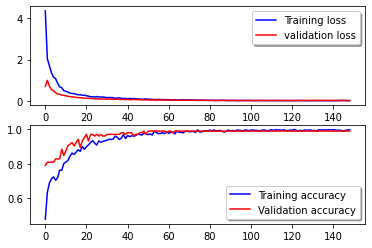

In [28]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
ax[0].plot(history.history['val_loss'], color='r', label = "validation loss", axes = ax[0])
legend = ax[0].legend(loc='best', shadow = True)

ax[1].plot(history.history['accuracy'], color = 'b', label = "Training accuracy")
ax[1].plot(history.history['val_accuracy'], color = 'r', label = "Validation accuracy")
legend = ax[1].legend(loc = 'best', shadow = True)

# 데이터 불균형으로 인해, val에 있는게 성능이 더 좋아보일 수도 있음

In [29]:
# 학습한거에서 test 어떻게 나오는지 확인 해보기
model = tf.keras.models.load_model(Config.base_path + 'best_model/wake_up_word_model')
for i in range(0,len(y_test) ):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[0.00503051]]
Answer: 0.0  Prediction: [[0.00027856]]
Answer: 0.0  Prediction: [[4.708421e-05]]
Answer: 0.0  Prediction: [[0.00077262]]
Answer: 0.0  Prediction: [[0.00230774]]
Answer: 0.0  Prediction: [[0.01168876]]
Answer: 0.0  Prediction: [[7.152445e-05]]
Answer: 0.0  Prediction: [[0.01934402]]
Answer: 1.0  Prediction: [[0.9999646]]
Answer: 0.0  Prediction: [[0.00161811]]
Answer: 0.0  Prediction: [[3.5578265e-05]]
Answer: 0.0  Prediction: [[0.14767703]]
Answer: 0.0  Prediction: [[0.00016251]]
Answer: 0.0  Prediction: [[0.0004207]]
Answer: 0.0  Prediction: [[0.00038768]]
Answer: 0.0  Prediction: [[4.8225877e-05]]
Answer: 0.0  Prediction: [[0.00021869]]
Answer: 0.0  Prediction: [[0.07640819]]
Answer: 0.0  Prediction: [[0.00182827]]
Answer: 1.0  Prediction: [[0.9926864]]
Answer: 0.0  Prediction: [[6.1804116e-05]]
Answer: 0.0  Prediction: [[4.7894835e-05]]
Answer: 1.0  Prediction: [[0.93899095]]
Answer: 0.0  Prediction: [[2.4803128e-05]]
Answer: 0.0  Prediction:

Answer: 0.0  Prediction: [[0.00513418]]
Answer: 1.0  Prediction: [[0.99989974]]
Answer: 0.0  Prediction: [[0.0589429]]
Answer: 0.0  Prediction: [[0.00027148]]
Answer: 1.0  Prediction: [[0.98616946]]
Answer: 0.0  Prediction: [[4.3446544e-05]]


In [30]:
loss, acc = model.evaluate(x=x_test, y=y_test)
print("loss=",loss)
print("acc=",acc)

7/7 [==============================] - 0s 15ms/step - loss: 0.0105 - accuracy: 1.0000
loss= 0.010512466542422771
acc= 1.0


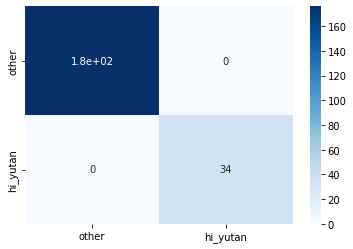

Thres - hold : 0.5
Test Accureacy:  1.0
Test Precision:  1.0
Test Recall:  1.0
Test F1 score:  1.0
Val 에서 1의 비율 : 19.05%
Test 에서 1의 비율 : 16.19%


In [32]:
Y_pred = model.predict(x_test)

predictions = []
for result in Y_pred:
  if result > Config.thres_hold:
      predictions.append(1)
  else:
      predictions.append(0)

confusion_mtx = metrics.confusion_matrix(y_test,predictions)
sns.heatmap(confusion_mtx,
            annot=True,
            xticklabels = Config.label,
            yticklabels = Config.label,
            cmap='Blues')
plt.show()
print("Thres - hold : {}".format(Config.thres_hold))
print('Test Accureacy: ',metrics.accuracy_score( y_test,predictions))
print('Test Precision: ',metrics.precision_score( y_test,predictions))
print('Test Recall: ',metrics.recall_score( y_test,predictions ))
print('Test F1 score: ',metrics.f1_score(y_test,predictions ))
print("Val 에서 1의 비율 : {}%".format(  round(list(y_val).count(1) / len(y_val)*100 , 2 )))
print("Test 에서 1의 비율 : {}%".format(  round(list(y_test).count(1) / len(y_test)*100 , 2 )))

# 기본 tflite 변환

In [33]:
if not os.path.exists(Config.base_path + 'tflite_model'):
    os.makedirs(Config.base_path + 'tflite_model')
    
model = tf.keras.models.load_model(Config.best_model_path)
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(Config.tflite_file_path, 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmpss3i4gq8\assets


893908

In [34]:
interpreter = tf.lite.Interpreter(model_path= Config.tflite_file_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'sequential_6_input', 'index': 0, 'shape': array([ 1, 20, 38,  1]), 'shape_signature': array([-1, 20, 38,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 27, 'shape': array([1, 1]), 'shape_signature': array([-1,  1]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


# Quantization 수행

In [21]:
import quantization 
from tensorflow.keras.models import load_model
import tensorflow_model_optimization as tfmot
from tensorflow import lite
import tensorflow as tf
from configuration import Config


model = tf.keras.models.load_model(Config.best_model_path)
tflite_model_quant = quantization.integer_quantization(model, x_train)



INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmpyon9ws9t\assets


INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmpyon9ws9t\assets


TypeError: 'generator' object is not callable

In [35]:
# Quantization을 위한 point 설정
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(x_train).batch(1).take(300):
    yield [input_value]

In [36]:
model = tf.keras.models.load_model(Config.best_model_path)

tflite_model_quant.integer_quantization()



# int 8 로 quantization 진행하기
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model_quant = converter.convert()

open(Config.quant_tflite_file_path, 'wb').write(tflite_model_quant)

INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmpwmcokl06\assets


INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmpwmcokl06\assets


236392

In [37]:
# Quantization 모델의 input, output 변환 잘 되었는지 확인 하기
interpreter = tf.lite.Interpreter(model_path = Config.quant_tflite_file_path)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


# Pruning 수행

In [38]:
import tempfile
model = tf.keras.models.load_model(Config.best_model_path)
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)

# Pruning을 위한 변수 설정
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
num_images = x_train.shape[0] * (1 - Config.validation_split_prun)
end_step = np.ceil(num_images / Config.batch_size_prun).astype(np.int32) * Config.epoch_prun

In [39]:
# Sparsity = 0.6,   pruning하고 다시 학습 시키기
pruning_params_6 = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.6,
                                                               begin_step=0,
                                                               end_step=-1,
                                                               frequency = 10
                                                               )
}

wake_pruning_6 = prune_low_magnitude(model, **pruning_params_6)

wake_pruning_6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

wake_pruning_6.fit(x_train, y_train,
                  batch_size=Config.batch_size_prun, epochs=Config.epoch_prun, validation_split=Config.validation_split_prun,
                  callbacks=callbacks)

C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/300


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\keras\backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


 3/37 [=>............................] - ETA: 3s - loss: nan - accuracy: 0.8333 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.0311s). Check your callbacks.


37/37 [==============================] - 7s 38ms/step - loss: nan - accuracy: 0.8031 - val_loss: nan - val_accuracy: 0.7432
Epoch 2/300
37/37 [==============================] - 1s 14ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 3/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 4/300
37/37 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 5/300
37/37 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 6/300
37/37 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 7/300
37/37 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 8/300
37/37 [==============================] - 1s 16ms

Epoch 61/300
37/37 [==============================] - ETA: 0s - loss: nan - accuracy: 0.793 - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 62/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 63/300
37/37 [==============================] - 1s 15ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 64/300
37/37 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 65/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 66/300
37/37 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 67/300
37/37 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
E

37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 121/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 122/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 123/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 124/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 125/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 126/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 127/300
37/37 [===========================

Epoch 238/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 239/300
37/37 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 240/300
37/37 [==============================] - 1s 16ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 241/300
37/37 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 242/300
37/37 [==============================] - 1s 17ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 243/300
37/37 [==============================] - 1s 18ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 244/300
37/37 [==============================] - 1s 18ms/step - loss: nan - accuracy: 0.7997 - val_loss: nan - val_accuracy: 0.7432
Epoch 245/300
37/37 [=============

In [40]:
pruning_6_eport = tfmot.sparsity.keras.strip_pruning(wake_pruning_6)

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(pruning_6_eport)
pruning_6_tflite = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmp7igsleaz\assets


INFO:tensorflow:Assets written to: C:\Users\yutan\AppData\Local\Temp\tmp7igsleaz\assets


In [42]:
open(Config.prun_tflite_file_path, "wb") .write(pruning_6_tflite)

892380

# tflite 평가 function

In [43]:
# tflite 모델 평가에서 사용되는 실행 함수
def run_tflite_model(tflite_file, test_image_indices):
  global x_test
  global y_test

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]


  fps = np.zeros((len(test_image_indices),))
  predictions = np.zeros((len(test_image_indices),), dtype=int)

  for i, test_image_index in enumerate(test_image_indices):
    test_image = x_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point
        
    start = time.time()
    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    end = time.time()
    
    fps[i] = (end - start)
    # thres_hold 설정 해주기

    if output > Config.thres_hold:
      output = 1
    else:
      outut = 0

    predictions[i] = output

  return predictions,fps

In [44]:
def evaluate_tflite_model(tflite_file, model_type):
  global x_test
  global x_test

  test_image_indices = range(x_test.shape[0])
  predictions, fps = run_tflite_model(tflite_file, test_image_indices)
  accuracy = (np.sum(y_test.reshape(-1)== predictions) * 100) / len(x_test)

  confusion_mtx = tf.math.confusion_matrix(y_test, predictions)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (model_type, accuracy, len(x_test)))

  sns.heatmap(confusion_mtx,
            annot=True,
            xticklabels = Config.label,
            yticklabels = Config.label,
            cmap='Blues')
  plt.show()

  print("FPS : ", 1 / np.mean(fps))
  print("Thres - hold : {}".format(Config.thres_hold))
  print('Test Accureacy: ',metrics.accuracy_score( y_test,predictions))
  print('Test Precision: ',metrics.precision_score( y_test,predictions))
  print('Test Recall: ',metrics.recall_score( y_test,predictions ))
  print('Test F1 score: ',metrics.f1_score(y_test,predictions ))
  print("Val 에서 1의 비율 : {}%".format(  round(list(y_val).count(1) / len(y_val)*100 , 2 )))
  print("Test 에서 1의 비율 : {}%".format(  round(list(y_test).count(1) / len(y_test)*100 , 2 )))





In [45]:
# # FPS 측정용 함수
# def run_tflite_time(tflite_file, test_image_indices):
#   global x_test
#   global y_test

#   # Initialize the interpreter
#   interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
#   interpreter.allocate_tensors()

#   input_details = interpreter.get_input_details()[0]
#   output_details = interpreter.get_output_details()[0]

#   fps = np.zeros((len(test_image_indices),))
#   for i, test_image_index in enumerate(test_image_indices):
#     test_image = x_test[test_image_index]
#     test_label = y_test[test_image_index]

#     # Check if the input type is quantized, then rescale input data to uint8
#     if input_details['dtype'] == np.uint8:
#       input_scale, input_zero_point = input_details["quantization"]
#       test_image = test_image / input_scale + input_zero_point

        
#     start = time.time()
#     test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
#     interpreter.set_tensor(input_details["index"], test_image)
#     interpreter.invoke()
#     output = interpreter.get_tensor(output_details["index"])[0]
#     end = time.time()
#     fps[i] = (end - start)

#   return fps

In [46]:
# # Change this to test a different image
# def test_model_time(tflite_file, model_type):
#   global x_test
#   test_image_indices = range(x_test.shape[0])
#   fps = run_tflite_time(tflite_file, test_image_indices)
#   print(np.mean(fps))
#   print("FPS : ", 1 / np.mean(fps))

In [47]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)
  print(os.path.getsize(zipped_file))

# tflite 결과 확인

In [48]:
import time

Float model accuracy is 100.0000% (Number of test samples=210)


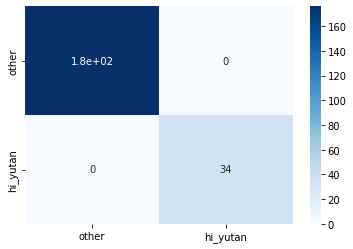

FPS :  9047.247627264884
Thres - hold : 0.5
Test Accureacy:  1.0
Test Precision:  1.0
Test Recall:  1.0
Test F1 score:  1.0
Val 에서 1의 비율 : 19.05%
Test 에서 1의 비율 : 16.19%
815939


In [49]:
evaluate_tflite_model(Config.tflite_file_path, model_type="Float")
get_gzipped_model_size(Config.tflite_file_path)
# 세로 - True
# 가로 - Prediction

Quantization model accuracy is 68.0952% (Number of test samples=210)


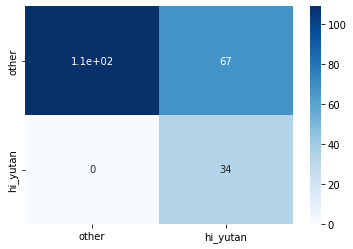

FPS :  46.28638704793984
Thres - hold : 0.5
Test Accureacy:  0.680952380952381
Test Precision:  0.33663366336633666
Test Recall:  1.0
Test F1 score:  0.5037037037037037
Val 에서 1의 비율 : 19.05%
Test 에서 1의 비율 : 16.19%
225126


In [50]:
evaluate_tflite_model(Config.quant_tflite_file_path, model_type="Quantization")
get_gzipped_model_size(Config.quant_tflite_file_path)

Pruning model accuracy is 83.8095% (Number of test samples=210)


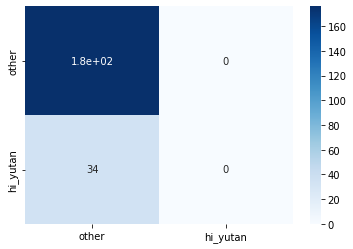

FPS :  8010.1475977846685
Thres - hold : 0.5
Test Accureacy:  0.8380952380952381
Test Precision:  0.0
Test Recall:  0.0
Test F1 score:  0.0
Val 에서 1의 비율 : 19.05%
Test 에서 1의 비율 : 16.19%
3070


C:\Users\yutan\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
evaluate_tflite_model(Config.prun_tflite_file_path, model_type="Pruning")
get_gzipped_model_size(Config.prun_tflite_file_path)